In [1]:
import numpy as np
import scipy.linalg as la
import math
import matplotlib.pyplot as plt
import time
import random

## 1. Quadratic problem. Extragradient.

\begin{equation}
\min_{x \in [-10; 10]^d} \max_{y \in [-10; 10]^d} f(x,y) = (x-b_x)^T A (y - b_y) + \frac{\lambda}{2}\| x - b_x\|^2 - \frac{\lambda}{2}\| y - b_y\|^2, \lambda = 1.
\end{equation}

In [2]:
def generate(d = 100, m = 1, L = 1000, border=10):

    if d == 1:
        lambdas = [m]
    if d == 2:
        lambdas = [m, L]
    if d > 2:
        lambdas = np.random.uniform(low=m, high=L, size=(d-2,))
        lambdas = lambdas.tolist() + [m, L]

    A = np.diag(lambdas)
    q, _ = la.qr(np.random.rand(d, d))
    A = q.T @ A @ q
    b_x = np.random.uniform(low=-border, high=border, size=(d,))
    b_y = np.random.uniform(low=-border, high=border, size=(d,))

    return A, b_x, b_y

In [3]:
L = 1000
m = 0.01
d = 100

A, b_x, b_y = generate(d=d, m=m, L=L)
z0 = np.random.uniform(low=-10, high=10, size=(2*d,))

In [4]:
def split(z):
    return np.split(z, 2)[0], np.split(z, 2)[1]

def merge(x, y):
    return np.concatenate((x, y), axis=None)

def err_norm(z):
    return np.linalg.norm(F(z), ord=2)**2

def err_R(z):
    x, y = split(z)
    return np.linalg.norm(x - b_x, ord=2)**2 + np.linalg.norm(y - b_y, ord=2)**2

def F(z):
    x, y = split(z)
    grad_x = A @ (y - b_y) + (x - b_x)
    grad_y = A.T @ (x - b_x) - (y - b_y)
    return merge(grad_x, -grad_y)

In [5]:
def extragradient(z0, gamma, error, iters=3000, eps=1e-12):

    z = z0
    z_vals = [z]
    times = [0.]
    errs = [error(z)]
    start = time.time()

    for i in range(0, iters-1):
        
        w = z - gamma * F(z)
        z = z - gamma * F(w)

        z_vals.append(z)
        times.append(time.time() - start)
        err = error(z)
        errs.append(err)
        if err < eps:
            break

    return z_vals, times, errs

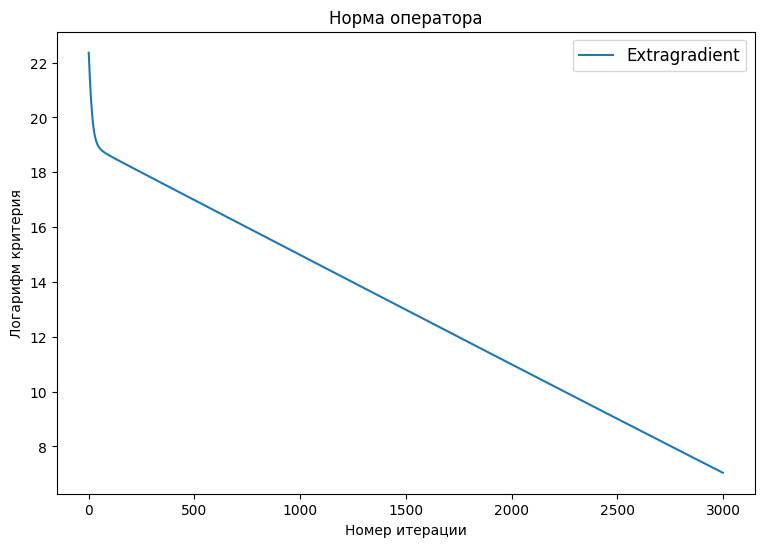

In [6]:
z_vals, times, errs = extragradient(z0, gamma=1/L, error=err_norm, iters=3000)

plt.figure(figsize=(9, 6))
plt.plot(range(len(errs)), np.log(errs), label='Extragradient')
plt.xlabel("Номер итерации")
plt.ylabel("Логарифм критерия")
plt.title('Норма оператора')
plt.legend(fontsize=12)
plt.show()

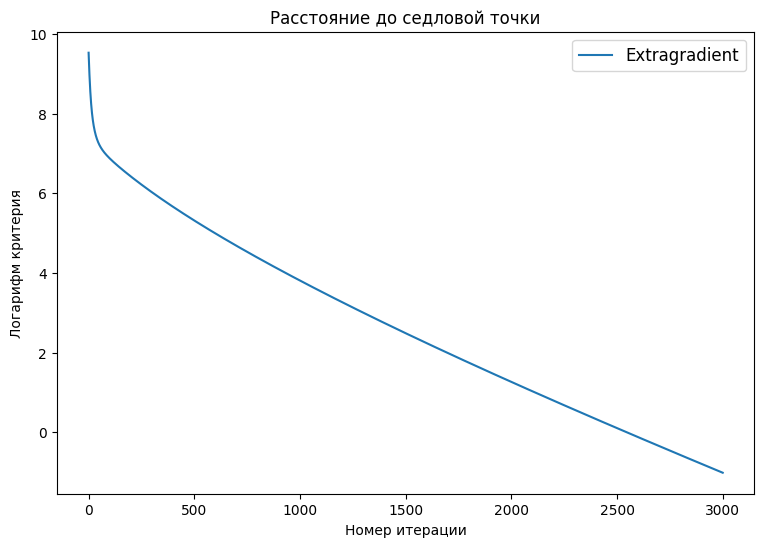

In [7]:
z_vals, times, errs = extragradient(z0, gamma=1/L, error=err_R, iters=3000)

plt.figure(figsize=(9, 6))
plt.plot(range(len(errs)), np.log(errs), label='Extragradient')
plt.xlabel("Номер итерации")
plt.ylabel("Логарифм критерия")
plt.title('Расстояние до седловой точки')
plt.legend(fontsize=12)
plt.show()

## 2. EAG-V test

In [8]:
def EAG_V(z0, gamma0=0.618/L, error=err_norm, iters=3000, eps=1e-12):

    z = z0
    gamma = gamma0
    z_vals = [z]
    times = [0.]
    errs = [error(z)]
    start = time.time()

    for i in range(0, iters-1):
        
        w = z + (z0 - z)/(i+2) - gamma * F(z)
        z = z + (z0 - z)/(i+2)- gamma * F(w)
        gamma = gamma * (1 - (gamma * L)**2 / ((i+1)*(i+3)*(1 - (gamma * L)**2)) )

        z_vals.append(z)
        times.append(time.time() - start)
        err = error(z)
        errs.append(err)
        if err < eps:
            break

    return z_vals, times, errs

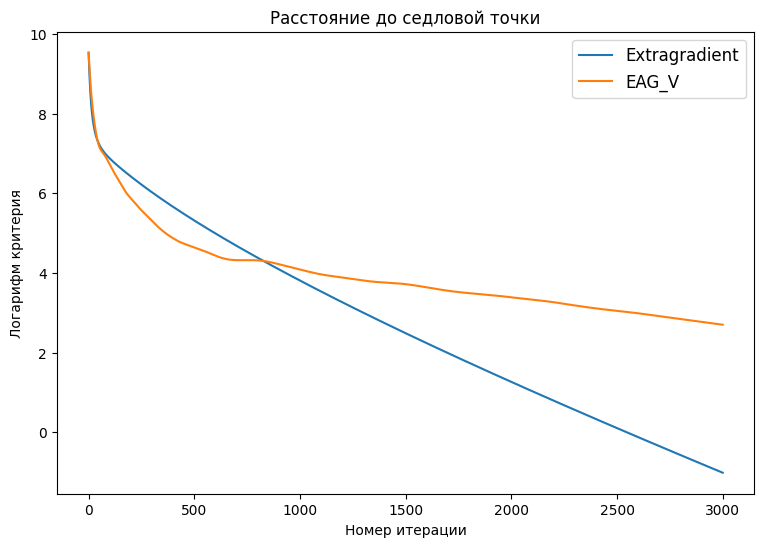

In [9]:
z_vals1, times1, errs1 = extragradient(z0, gamma=1/L, error=err_R, iters=3000)
z_vals2, times2, errs2 = EAG_V(z0, gamma0 = 0.618/L,error=err_R, iters=3000)

plt.figure(figsize=(9, 6))
plt.plot(range(len(errs1)), np.log(errs1), label='Extragradient')
plt.plot(range(len(errs2)), np.log(errs2), label='EAG_V')
plt.xlabel("Номер итерации")
plt.ylabel("Логарифм критерия")
plt.title('Расстояние до седловой точки')
plt.legend(fontsize=12)
plt.show()

EAG-V с $\alpha_0 = \frac{0.618}{L}$ удовлетворяет:
\begin{equation}
    \|F(z^k)\|^2 \leq \dfrac{27L^2\|z^0 - z^*\|^2}{(k+1)(k+2)}, k \geq 0.
\end{equation}

Страница 4 статьи https://arxiv.org/pdf/2102.07922.pdf

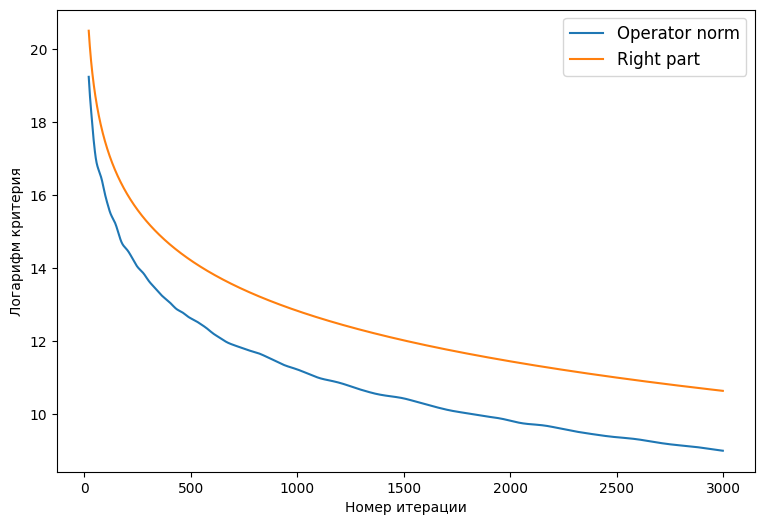

In [10]:
z_vals, times, errs = EAG_V(z0, error=err_norm, iters=3000)
z_opt = merge(b_x, b_y)
C = 27 * L**2 * np.linalg.norm(z0 - z_opt, ord=2)**2
start = 20

plt.figure(figsize=(9, 6))
plt.plot(range(start, len(errs)), np.log(errs[start:]), label='Operator norm')
plt.plot(range(start, len(errs)), [np.log(C/((k+1)*(k+2))) for k in range(start, len(errs))], label='Right part')
plt.xlabel("Номер итерации")
plt.ylabel("Логарифм критерия")
plt.legend(fontsize=12)
plt.show()

## 3. EAG-V for our experiment

$u^k -$ выход EAG-V, $\tilde u^k - $ точное решение подзадачи.

EAG-V останавливается, когда достигается оценка:

\begin{equation}
    \|B(u^k)\|^2 \leq \frac{L_p^2}{3} \|x^k - \tilde u^k \|^2
\end{equation}

Запускать EAG-V будем из точки $x^k$. Тогда справедливо:
\begin{equation}
    \|B(u^k)\|^2 \leq \dfrac{27L^2\|x^k - \tilde u^k\|^2}{(k+1)(k+2)}, k \geq 0.
\end{equation}

$B$ является $(2L_p + L_q)-$Липшецевым, т.е. $L = 2L_p + L_q$. Имеем:
\begin{equation}
    \dfrac{27L^2\|x^k - \tilde u^k\|^2}{(k+1)(k+2)} \leq \frac{L_p^2}{3} \|x^k - \tilde u^k \|^2
\end{equation}

\begin{equation}
    \dfrac{81(2L_p + L_q)^2}{L_p^2} \leq (k+1)(k+2)
\end{equation}

Такое число итераций потребуется для решения подзадачи, чтобы выполнилось предположение на норму $B$.